In [1]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz

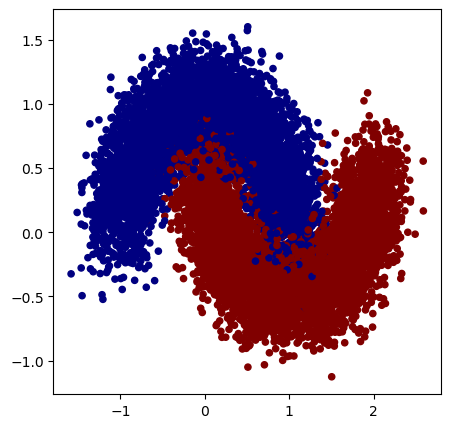

In [15]:
#creating inputs

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=10000, noise=0.2)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [16]:
super_nn = MLP(2, [8, 8, 1]) #2 inputs, 2 layers===> layer1=6 nodes AND layer2=6 nodes ||| 1 output
print(super_nn)

print("parameters of the nn: ", len(super_nn.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8)], Layer of [LinearNeuron(8)]]
parameters of the nn:  105


In [17]:
#calculate the loss // training evaluation step


def loss(batch_size=None):
#batch_size for SGD
    if batch_size is None:
        #if batch_size is None uses the entire dataset
        Xb, yb = X,y
    else:
        #else run micro batches
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    inputs = [list(map(Value, xrow)) for xrow in Xb]

    #forward
    scores = list(map(super_nn, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
   
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in super_nn.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss() 
print(total_loss, acc)


Value(data=1.06319626792313, grad=0) 0.3874


In [18]:
#now the optimization process

for k in range(200):

    #forward
    total_loss, acc = loss(batch_size=100)

    #backward
    super_nn.zero_grad()
    total_loss.backward()

    #update sgd
    learn_rate = 1.0 - 0.9*k/200
    for p in super_nn.parameters():
            p.data -=learn_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.0331652268011007, accuracy 42.0%
step 1 loss 0.6936118768933197, accuracy 68.0%
step 2 loss 0.7976715021953918, accuracy 75.0%
step 3 loss 0.8770595917597377, accuracy 68.0%
step 4 loss 0.6480192151697859, accuracy 77.0%
step 5 loss 0.42782087051280654, accuracy 80.0%
step 6 loss 0.36421134886301165, accuracy 87.0%
step 7 loss 0.36237389122766495, accuracy 84.0%
step 8 loss 0.3892626541746857, accuracy 82.0%
step 9 loss 0.34690118236746126, accuracy 84.0%
step 10 loss 0.28964124778314954, accuracy 88.0%
step 11 loss 0.24985601940117227, accuracy 89.0%
step 12 loss 0.3149935709092237, accuracy 87.0%
step 13 loss 0.5904087882724067, accuracy 76.0%
step 14 loss 0.28263270521605455, accuracy 88.0%
step 15 loss 0.2234077238953791, accuracy 90.0%
step 16 loss 0.1458827367713574, accuracy 95.0%
step 17 loss 0.2106257310411464, accuracy 92.0%
step 18 loss 0.2601981144693784, accuracy 87.0%
step 19 loss 0.28470146340281427, accuracy 89.0%
step 20 loss 0.28583159778501743, accuracy

(-2.1251397857229772, 2.3748602142770228)

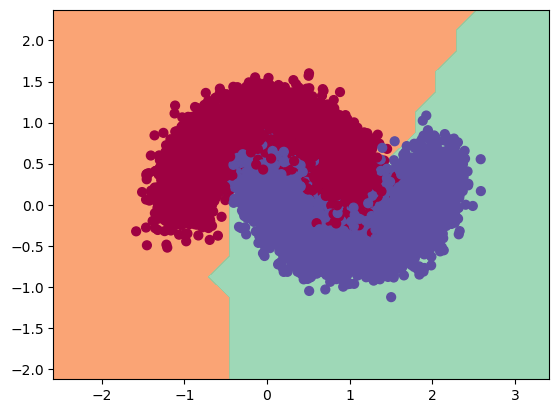

In [19]:

# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
                     
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(super_nn, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())